In [1]:
import os
import math
from pyspark import SparkConf, SparkContext
f = open("/Users/mencher/Projects/big_data/Outputfile.txt", 'a')

In [2]:
conf = SparkConf().setMaster("local").setAppName("pagerank")
sc = SparkContext.getOrCreate(conf=conf)

totalPointNum = 0
totalDimemsions = 58

def expandPointData(lines):
    global totalPointNum
    # totalPointNum could be "C_id" or "P_id", depends on who calls it.
    splitedItems = []
    for perLine in lines.splitlines():
        for dimemIdx, perDimem in enumerate(perLine.split(' ')):
            splitedItems.append((dimemIdx, (totalPointNum, float(perDimem))))
        totalPointNum = totalPointNum + 1
    return splitedItems
    

def tidyPointData(lines):
    global totalPointNum
    splitedItems = []
    for perLine in lines.splitlines():
        splitedItems.append((totalPointNum, perLine.split(' ')))
        totalPointNum = totalPointNum + 1
    return splitedItems

def calculateEucli(val):
    myPointIdx = val[1][0][0]
    myPointVal = val[1][0][1]
    cPointIdx = val[1][1][0]
    cPointVal = val[1][1][1]
    return ((myPointIdx, cPointIdx), (myPointVal - cPointVal)**2)

def calculateManhat(val):
    myPointIdx = val[1][0][0]
    myPointVal = val[1][0][1]
    cPointIdx = val[1][1][0]
    cPointVal = val[1][1][1]
    return ((myPointIdx, cPointIdx), abs(myPointVal - cPointVal))

def findOptimalCPoint(val):
    clusterMap = []
    smallestCIdx = 0
    smallestCVal = 9999999999
    for perVal in val[1]:
        if (perVal[1] < smallestCVal):
            smallestCIdx = perVal[0]
            smallestCVal = perVal[1]
    clusterMap.append((val[0], (smallestCIdx, smallestCVal)))
    return clusterMap 

def retidyMergeData(val):
    cPointIdx = val[1][0][0]
    myPointVal = val[1][1]
    return (cPointIdx, myPointVal)

def calculateMean(val):
    totalPointNum = 0
    pointData = [0]*totalDimemsions
    iterationTimes = int(len(val[1])/totalDimemsions)
    for idx in range(iterationTimes):
        for dimemIdx in range(totalDimemsions):
            pointData[dimemIdx] = pointData[dimemIdx] + float(val[1][idx*totalDimemsions + dimemIdx])
        totalPointNum = totalPointNum + 1
    for dimemIdx in range(totalDimemsions):
        pointData[dimemIdx] = (pointData[dimemIdx]/totalPointNum)
    return (val[0], pointData)

pointData = sc.textFile("./data.txt").flatMap(expandPointData)
pointAllDimems = sc.textFile("./data.txt").flatMap(tidyPointData)
c1Data = sc.textFile("./c1.txt").flatMap(expandPointData)
c2Data = sc.textFile("./c2.txt").flatMap(expandPointData)

# ONLY FOR DRAWING GRAPH!!! NOT OUR IMPLEMENTATION!!!
costDataMC1 = []
costDataMC2 = []
costDataEC1 = []
costDataEC2 = []

finalDataMC1 = []
finalDataMC2 = []
finalDataEC1 = []
finalDataEC2 = []


def main_function(cData, costData, minimizeFunc):
    for _ in range(20):
        # First Step: Assign P to cluster with the closest centroid
        # Get (currentPoint, [ (cPoint1, CPoint1DimemTotalDistance), (cPoint2, CPoint2DimemTotalDistance) ...... ])
        eucliResult = pointData.join(cData).map(minimizeFunc).reduceByKey(lambda x, y: x+y).map(lambda val: (val[0][0], [(val[0][1], val[1])])).reduceByKey(lambda x, y: x+y)
        # Map would return "point_id: cluster_id"
        midResult = eucliResult.flatMap(findOptimalCPoint)

        # ONLY FOR DRAWING GRAPH!!! NOT OUR IMPLEMENTATION!!!
        preCostData = midResult.map(lambda val: val[1][1]).collect()
        costData.append(sum(preCostData))

        # Second Step: Each Cluster Recompute, Get (C_id, [ALL_DIMEMSION_DATA])
        finalResult = midResult.join(pointAllDimems).map(retidyMergeData).reduceByKey(lambda x, y: x + y).map(calculateMean)
        # Final Step: Transform C datatype for iterative computation
        cData = finalResult.flatMap(lambda val: [(dimemIdx, (val[0], perDimem)) for dimemIdx, perDimem in enumerate(val[1])] )
    return finalResult


finalDataMC1 = main_function(c1Data, costDataMC1, calculateManhat).collect()
finalDataMC2 = main_function(c2Data, costDataMC2, calculateManhat).collect()
finalDataEC1 = main_function(c1Data, costDataEC1, calculateEucli).collect()
finalDataEC2 = main_function(c2Data, costDataEC2, calculateEucli).collect()

print(costDataMC1)        
print(costDataMC2)

print(costDataEC1)
print(costDataEC2)

print(finalDataMC1)
print(finalDataMC2)
print(finalDataEC1)
print(finalDataEC2)


[550117.1420000008, 465712.70324759476, 470784.6625350566, 483755.4888982298, 489177.81057797244, 487605.86973062734, 483556.10627122154, 475329.2376143043, 474871.2388463639, 457232.9201150768, 447494.3861973498, 450915.0125766767, 451250.3670725645, 451974.59553974954, 451570.3640699556, 452739.0113664551, 453082.7302871827, 450583.6708602983, 450368.7493167403, 449011.36372551974]
[1433739.309999992, 1084488.776964878, 973431.7146620409, 895934.5925630704, 865128.3352940789, 845846.6470313481, 827219.5827561227, 803590.3456011108, 756039.5172761208, 717332.9025432296, 694587.9252526875, 684444.5019967918, 674574.7475478575, 667409.4699160273, 663556.6278214996, 660162.7772287563, 656041.3222947118, 653036.7540731622, 651112.4262522724, 649689.0131843543]
[623660345.3064165, 509862908.29754645, 485480681.8720072, 463997011.68501157, 460969266.57299733, 460537847.9827703, 460313099.6535444, 460003523.889407, 459570539.3177352, 459021103.3422907, 458490656.19198155, 457944232.5879735, 

In [53]:
import csv
totalK = 10

def euliDistance(pointA, pointB):
    totalSum = 0
    for dimemIdx in range(totalDimemsions):
        totalSum = totalSum + (pointA[1][dimemIdx] - pointB[1][dimemIdx])**2
    return math.sqrt(totalSum)

def manhDistance(pointA, pointB):
    totalSum = 0
    for dimemIdx in range(totalDimemsions):
        totalSum = totalSum + abs(pointA[1][dimemIdx] - pointB[1][dimemIdx])
    return totalSum


def exportDistance(arrayList, calculateFunc, fileName):
    result = []
    for curIdx in range(totalK):
        mid_result = []
        for comparedIdx in range(totalK):
            if (curIdx > comparedIdx): mid_result.append('')
            elif (curIdx == comparedIdx): mid_result.append(0)
            else:
                calc_result = calculateFunc(arrayList[curIdx], arrayList[comparedIdx])
                final_calc_result = "{:.3f}".format(calc_result)
                mid_result.append(final_calc_result)
        result.append(mid_result)
        mid_result = []
    with open(fileName, 'w', newline='') as csvfile:
      writer = csv.writer(csvfile)
      title_list = [''] + [idx for idx in range(10)]
      writer.writerow(title_list)
      for idx, val in enumerate(result):
        date_str = idx + 1
        val = [date_str] + val
        writer.writerow(val)

exportDistance(finalDataMC1, euliDistance, 'eu_mc1.csv')
exportDistance(finalDataMC1, manhDistance, 'ma_mc1.csv')
exportDistance(finalDataMC2, euliDistance, 'eu_mc2.csv')
exportDistance(finalDataMC2, manhDistance, 'ma_mc2.csv')
exportDistance(finalDataEC1, euliDistance, 'eu_ec1.csv')
exportDistance(finalDataEC1, manhDistance, 'ma_ec1.csv')
exportDistance(finalDataEC2, euliDistance, 'eu_ec2.csv')
exportDistance(finalDataEC2, manhDistance, 'ma_ec2.csv')
print('Finish!')

Finish!


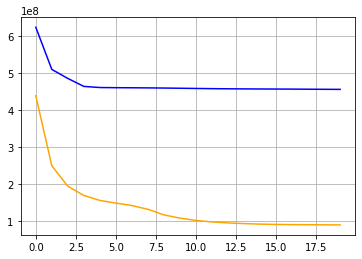

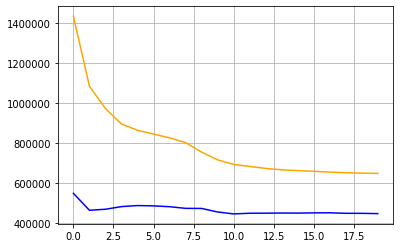

In [40]:
import matplotlib.pyplot as plt

newCostDataEC1 = [ "{:.3f}".format(item) for item in costDataEC1 ]
newCostDataEC2 = [ "{:.3f}".format(item) for item in costDataEC2 ]
newCostDataMC1 = [ "{:.3f}".format(item) for item in costDataMC1 ]
newCostDataMC2 = [ "{:.3f}".format(item) for item in costDataMC2 ]


with open('eu_cost.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    title_list = [''] + ['Round' + str(idx+1) for idx in range(20)]
    writer.writerow(title_list)

    second_row = ['C1'] + newCostDataEC1
    writer.writerow(second_row)
    
    third_row = ['C2'] + newCostDataEC2
    writer.writerow(third_row)
    
with open('mc_cost.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    title_list = [''] + ['Round' + str(idx+1) for idx in range(20)]
    writer.writerow(title_list)

    second_row = ['C1'] + newCostDataMC1
    writer.writerow(second_row)
    
    third_row = ['C2'] + newCostDataMC2
    writer.writerow(third_row)


plt.plot(costDataEC1, color="blue")
plt.plot(costDataEC2, color="orange")
plt.grid(True)
plt.show()

plt.plot(costDataMC1, color="blue")
plt.plot(costDataMC2, color="orange")
plt.grid(True)
plt.show()